In [ ]:
! pip install pyreadstat
! pip install scikit-plot
#! pip install keras-tuner
#! pip install parfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Load Python packages
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression #Logistic Regression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
import pyreadstat
%matplotlib inline


#ANN (not utilized in further analysis)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD, RMSprop
import seaborn as sns
import tensorflow as tf
from keras import losses
from sklearn.utils import shuffle

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

#Balancing
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.utils import shuffle

In [ ]:
#Mount and load dataset

from google.colab import drive
drive.mount('/content/drive')

df, meta = pyreadstat.read_sav("/content/drive/MyDrive/Thyroid_data.sav")
type(df)
#df
print(df.info())

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tsh1                   1800 non-null   float64
 1   ft41                   1800 non-null   float64
 2   tpo1                   1800 non-null   float64
 3   Vermoeid_12            1800 non-null   float64
 4   Doorslaapprob_12       1800 non-null   float64
 5   Vergeetachtig_12       1800 non-null   float64
 6   Concentratie_12        1800 non-null   float64
 7   Benauwd_12             1800 non-null   float64
 8   Krampbenen_12          1800 non-null   float64
 9   Vochthandvoet_12       1800 non-null   float64
 10  Vocht_12               1800 non-null   float64
 11  Pijnspieren_12         1800 non-null   float64
 12  Pijngewrichten_12      1800 non-null   float64
 13  Piekeren_12            1800 non-null   float64
 14  Wisselendestemming_12  1800 no

In [ ]:
#Feature subsets according to SPSA

dfrf = df.drop(['tsh1', 'ft41', 'tpo1', 'Doorslaapprob_12', 'Vochthandvoet_12'], axis=1)
dflr = df.drop(['tsh1', 'ft41', 'tpo1', 'Wisselendestemming_12', 'Piekeren_12', 'Pijngewrichten_12'], axis=1)
dfknn = df.drop(['tsh1', 'ft41', 'tpo1', 'Vocht_12', 'Pijnspieren_12'], axis=1)
dfsvm = df.drop(['tsh1', 'ft41', 'tpo1', 'Vochthandvoet_12', 'Pijnspieren_12'], axis=1)

dfrf = dfrf.to_numpy() 
dflr = dflr.to_numpy() 
dfknn = dfknn.to_numpy() 
dfsvm = dfsvm.to_numpy() 

Xrf = dfrf[:,:-1]
yrf = dfrf[:,-1]

Xlr = dflr[:,:-1]
ylr = dflr[:,-1]

Xknn = dfknn[:,:-1]
yknn= dfknn[:,-1]

Xsvm = dfsvm[:,:-1]
ysvm = dfsvm[:,-1]


In [ ]:
#SMOTE subsets

from imblearn.combine import SMOTETomek
smote_tom = SMOTETomek(random_state=1)

X_rf, y_rf = smote_tom.fit_resample(Xrf, yrf.ravel())
X_lr, y_lr = smote_tom.fit_resample(Xlr, ylr.ravel())
X_knn, y_knn = smote_tom.fit_resample(Xknn, yknn.ravel())
X_svm, y_svm = smote_tom.fit_resample(Xsvm, ysvm.ravel())

print("SMOTETomek RF: ", sorted(Counter(y_rf).items()), X_rf.shape, y_rf.shape)
print("SMOTETomek LR: ", sorted(Counter(y_lr).items()), X_lr.shape, y_lr.shape)
print("SMOTETomek KNN: ", sorted(Counter(y_knn).items()), X_knn.shape, y_knn.shape)
print("SMOTETomek SVM: ", sorted(Counter(y_svm).items()), X_svm.shape, y_svm.shape)

SMOTETomek RF:  [(1.0, 1613), (2.0, 1613), (3.0, 1610), (4.0, 1605), (5.0, 1609), (6.0, 1607), (7.0, 1609)] (11266, 10) (11266,)
SMOTETomek LR:  [(1.0, 1613), (2.0, 1611), (3.0, 1611), (4.0, 1604), (5.0, 1599), (6.0, 1610), (7.0, 1596)] (11244, 9) (11244,)
SMOTETomek KNN:  [(1.0, 1613), (2.0, 1614), (3.0, 1613), (4.0, 1603), (5.0, 1610), (6.0, 1606), (7.0, 1613)] (11272, 10) (11272,)
SMOTETomek SVM:  [(1.0, 1613), (2.0, 1614), (3.0, 1609), (4.0, 1605), (5.0, 1609), (6.0, 1607), (7.0, 1613)] (11270, 10) (11270,)


In [ ]:
#Subset Preprocessing 

from sklearn.model_selection import StratifiedShuffleSplit

le = LabelEncoder()
y_rf = le.fit_transform(y_rf)
y_lr = le.fit_transform(y_lr)
y_knn = le.fit_transform(y_knn)
y_svm = le.fit_transform(y_svm)

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=2)
sss.get_n_splits(X_rf, y_rf)
sss.get_n_splits(X_lr, y_lr)
sss.get_n_splits(X_knn, y_knn)
sss.get_n_splits(X_svm, y_svm)

for train_index, test_index in sss.split(X_rf, y_rf):
  X_rftrain, X_rftest = X_rf[train_index], X_rf[test_index]
  y_rftrain, y_rftest = y_rf[train_index], y_rf[test_index]

for train_index, test_index in sss.split(X_lr, y_lr):
  X_lrtrain, X_lrtest = X_lr[train_index], X_lr[test_index]
  y_lrtrain, y_lrtest = y_lr[train_index], y_lr[test_index]

for train_index, test_index in sss.split(X_knn, y_knn):
  X_knntrain, X_knntest = X_knn[train_index], X_knn[test_index]
  y_knntrain, y_knntest = y_knn[train_index], y_knn[test_index]

for train_index, test_index in sss.split(X_svm, y_svm):
  X_svmtrain, X_svmtest = X_svm[train_index], X_svm[test_index]
  y_svmtrain, y_svmtest = y_svm[train_index], y_svm[test_index]

print("Train targets RF:", sorted(Counter(y_rftrain).items()))
print("Test targets RF:", sorted(Counter(y_rftest).items()))

print("Train targets LR:", sorted(Counter(y_lrtrain).items()))
print("Test targets LR:", sorted(Counter(y_lrtest).items()))

print("Train targets KNN:", sorted(Counter(y_knntrain).items()))
print("Test targets KNN:", sorted(Counter(y_knntest).items()))

print("Train targets SVM:", sorted(Counter(y_svmtrain).items()))
print("Test targets SVM:", sorted(Counter(y_svmtest).items()))

print("RF, LR, KNN, SVM training shapes:", X_rftrain.shape, X_lrtrain.shape, X_knntrain.shape, X_svmtrain.shape)

Train targets RF: [(0, 1290), (1, 1290), (2, 1288), (3, 1284), (4, 1287), (5, 1286), (6, 1287)]
Test targets RF: [(0, 323), (1, 323), (2, 322), (3, 321), (4, 322), (5, 321), (6, 322)]
Train targets LR: [(0, 1290), (1, 1289), (2, 1289), (3, 1283), (4, 1279), (5, 1288), (6, 1277)]
Test targets LR: [(0, 323), (1, 322), (2, 322), (3, 321), (4, 320), (5, 322), (6, 319)]
Train targets KNN: [(0, 1290), (1, 1291), (2, 1290), (3, 1283), (4, 1288), (5, 1285), (6, 1290)]
Test targets KNN: [(0, 323), (1, 323), (2, 323), (3, 320), (4, 322), (5, 321), (6, 323)]
Train targets SVM: [(0, 1290), (1, 1291), (2, 1287), (3, 1284), (4, 1287), (5, 1286), (6, 1291)]
Test targets SVM: [(0, 323), (1, 323), (2, 322), (3, 321), (4, 322), (5, 321), (6, 322)]
RF, LR, KNN, SVM training shapes: (9012, 10) (8995, 9) (9017, 10) (9016, 10)


In [ ]:
#Standardization

scaler = StandardScaler()
X_rftrain = scaler.fit_transform(X_rftrain)
X_rftest = scaler.fit_transform(X_rftest)

X_lrtrain = scaler.fit_transform(X_lrtrain)
X_lrtest = scaler.fit_transform(X_lrtest)

X_knntrain = scaler.fit_transform(X_knntrain)
X_knntest = scaler.fit_transform(X_knntest)

X_svmtrain = scaler.fit_transform(X_svmtrain)
X_svmtest = scaler.fit_transform(X_svmtest)

LR

In [ ]:
#Base Logistic Regression model

import random
random.seed(10)

baseLR = LogisticRegression(multi_class='multinomial',random_state = 1)
baseLR.fit(X_lrtrain, y_lrtrain)

LogisticRegression(multi_class='multinomial', random_state=1)

0.3170297910182303
ROC-AUC LR:  0.6902016555094163


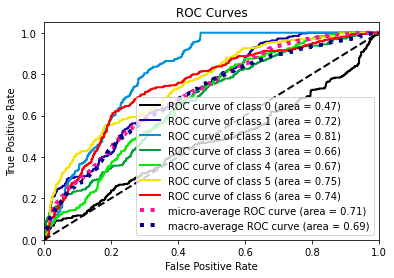

              precision    recall  f1-score   support

     Class 0       0.25      0.04      0.07       323
     class 1       0.37      0.40      0.39       322
     class 2       0.32      0.55      0.40       322
     Class 3       0.18      0.23      0.20       321
     class 4       0.26      0.18      0.21       320
     class 5       0.50      0.43      0.46       322
     Class 6       0.32      0.39      0.35       319

    accuracy                           0.32      2249
   macro avg       0.32      0.32      0.30      2249
weighted avg       0.32      0.32      0.30      2249



In [ ]:
#Predictions
random.seed(11)

predictions1 = baseLR.predict(X_lrtest) #predictions
y_score1 = baseLR.predict_proba(X_lrtest)
score1 = baseLR.score(X_lrtest, y_lrtest)
print(score1)
print("ROC-AUC LR: ",roc_auc_score(y_lrtest, y_score1, multi_class='ovr'))
plot_roc(y_lrtest, y_score1)
plt.show()

target_names = ['Class 0', 'class 1', 'class 2', 'Class 3', 'class 4', 'class 5', 'Class 6']
print(classification_report(y_lrtest, predictions1, target_names=target_names))


In [ ]:
#Hyperparameter tuning

from sklearn.model_selection import RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=36)

LogisticRegression()

LRgrid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.001, 0.01, 0.1, 1.0, 10],
    'max_iter' : [1000, 2000,3000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.1, 0.25, 0.5, 0.75],
    'random_state' : [18]
}

lr_grid = GridSearchCV(estimator=baseLR, param_grid=LRgrid, cv=rskf)
lr_grid.fit(X_lrtrain, y_lrtrain)

In [ ]:
#Best parameters

lr_cv.best_params_ #Best parameters

RF

In [ ]:
#Base RF model

rf=RandomForestClassifier(bootstrap = True, oob_score= True)

#Best par: {'criterion': 'entropy',
# 'max_features': 4,
# 'min_samples_leaf': 7,
# 'n_estimators': 500}
#Train the model using the training sets y_pred=clf.predict(X_test)
rf.fit(X_rftrain,y_rftrain)

y_pred2=rf.predict(X_rftest)
y_score2 = rf.predict_proba(X_rftest)

Accuracy RF : 0.7582076308784383
ROC-AUC RF : 0.9667051906708151


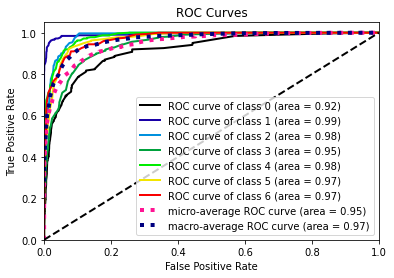

              precision    recall  f1-score   support

     Class 0       0.89      0.34      0.50       323
     class 1       0.73      0.98      0.84       323
     class 2       0.79      0.86      0.83       322
     Class 3       0.82      0.57      0.67       321
     class 4       0.79      0.86      0.82       322
     class 5       0.76      0.82      0.79       321
     Class 6       0.66      0.88      0.75       322

    accuracy                           0.76      2254
   macro avg       0.78      0.76      0.74      2254
weighted avg       0.78      0.76      0.74      2254

[0 1 2 3 4 5 6]


In [ ]:
#Evaluation criteria

print("Accuracy RF :", accuracy_score(y_rftest, y_pred2))
print("ROC-AUC RF :",roc_auc_score(y_rftest, y_score2, multi_class='ovr'))
plot_roc(y_rftest, y_score2)
plt.show()

target_names = ['Class 0', 'class 1', 'class 2', 'Class 3', 'class 4', 'class 5', 'Class 6']
print(classification_report(y_rftest, y_pred2, target_names=target_names))

print(np.unique(y_pred2))

In [ ]:
#Hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=36)

rfgrid = { 
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [7, 9, 11, 13]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rfgrid, cv=rskf, refit=True, verbose=3)
rf_grid.fit(X_rftrain, y_rftrain)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV 1/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.925 total time=   1.3s
[CV 2/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.953 total time=   1.3s
[CV 3/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.942 total time=   1.3s
[CV 4/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.947 total time=   1.2s
[CV 5/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.957 total time=   1.2s
[CV 6/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.942 total time=   1.3s
[CV 7/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.947 total time=   1.2s
[CV 8/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.953 total time=   1.2s
[CV 9/10] END max_features=sqrt, min_samples_leaf=7, n_estimators=100;, score=0.946 total time=   1.3s
[CV 10/10]

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=36),
             estimator=RandomForestClassifier(max_features='log2',
                                              min_samples_leaf=9,
                                              min_samples_split=8,
                                              oob_score=True),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [7, 9, 11, 13],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=3)

In [ ]:
#Best parameters

rf_grid.best_params_

{'max_features': 'log2', 'min_samples_leaf': 7, 'n_estimators': 500}

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier(algorithm='auto')
knn.fit(X_knntrain,y_knntrain)
predknn=knn.predict(X_knntest)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("ROC-AUC KNN :",roc_auc_score(y_knntest, y_score2, multi_class='ovr'))
result = confusion_matrix(y_knntest, predknn)
print("Confusion Matrix:")
print(result)
result1 = classification_report(y_knntest, predknn)
print("Classification Report:")
print (result1)
result2 = accuracy_score(y_knntest,predknn)
print("Accuracy:",result2)

Confusion Matrix:
[[155  12  22  45  19  41  29]
 [  0 322   0   0   0   0   1]
 [  0   0 322   0   0   1   0]
 [  3   0   0 309   1   6   1]
 [  1   2   0   8 311   0   0]
 [  2   1  13   6   1 297   1]
 [  6   0   0   3   0   3 311]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.63       323
           1       0.96      1.00      0.98       323
           2       0.90      1.00      0.95       323
           3       0.83      0.97      0.89       320
           4       0.94      0.97      0.95       322
           5       0.85      0.93      0.89       321
           6       0.91      0.96      0.93       323

    accuracy                           0.90      2255
   macro avg       0.90      0.90      0.89      2255
weighted avg       0.90      0.90      0.89      2255

Accuracy: 0.8988913525498892


0.8988913525498892
Accuracy: 0.8988913525498892
ROC-AUC KNN : 0.981272050556061


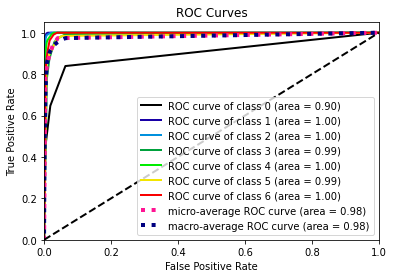

              precision    recall  f1-score   support

     Class 0       0.93      0.48      0.63       323
     class 1       0.96      1.00      0.98       323
     class 2       0.90      1.00      0.95       323
     Class 3       0.83      0.97      0.89       320
     class 4       0.94      0.97      0.95       322
     class 5       0.85      0.93      0.89       321
     Class 6       0.91      0.96      0.93       323

    accuracy                           0.90      2255
   macro avg       0.90      0.90      0.89      2255
weighted avg       0.90      0.90      0.89      2255



In [ ]:
from sklearn.metrics import accuracy_score
import random
random.seed(12)

y_scoreknn = knn.predict_proba(X_knntest)
scoreknn = knn.score(X_knntest, y_knntest)
print(scoreknn)
print('Accuracy:',accuracy_score(y_knntest, predknn))

print("ROC-AUC KNN :",roc_auc_score(y_knntest, y_scoreknn, multi_class='ovr'))
plot_roc(y_knntest, y_scoreknn)
plt.show()

target_names = ['Class 0', 'class 1', 'class 2', 'Class 3', 'class 4', 'class 5', 'Class 6']
print(classification_report(y_knntest, predknn, target_names=target_names))

In [ ]:
#Hyperparameter tuning

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=38)
leaf_size = list(range(1,50))
n_neighbors = list(range(1,10))

# Defining parameter range
gridknn = {'n_neighbors' :  n_neighbors,
           'weights': ['uniform', 'distance'], 
           'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
           'metric' : ['manhattan', 'minkowski', 'euclidian']}
           
  
grid_knn = GridSearchCV(knn, gridknn, refit = True, verbose = 3, cv=rskf)
  
# fitting the model for grid search
grid_knn.fit(X_knntrain, y_knntrain)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
[CV 1/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.959 total time=   0.1s
[CV 2/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.951 total time=   0.1s
[CV 3/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.961 total time=   0.1s
[CV 4/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.958 total time=   0.1s
[CV 5/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.971 total time=   0.1s
[CV 6/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.957 total time=   0.1s
[CV 7/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.945 total time=   0.1s
[CV 8/10] END algorithm=auto, metric=manhattan, n_neighbors=1, p=1, weights=uniform;, score=0.959 total time=   0.1s

KeyboardInterrupt: ignored

In [ ]:
#Best parameters

grid_knn.best_params_ 

SVM

In [ ]:
#Base SVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

svc = SVC(gamma='auto')

rbf = SVC(kernel='rbf', decision_function_shape='ovr',probability=True).fit(X_svmtrain, y_svmtrain) 
rbf_pred = rbf.predict(X_svmtest)

In [ ]:
rbf_pred = rbf.predict(X_svmtest)
accuracy_rbf = rbf.score(X_svmtest, y_svmtest)
#accuracy_sig = sig.score(X_test, y_test)
#print("Accuracy Linear Kernel:", accuracy_lin)
#print("Accuracy Poly Kernel:", accuracy_poly)
print("Accuracy RBF Kernel:", accuracy_rbf)

Accuracy RBF Kernel: 0.8802129547471162


0.8802129547471162
Accuracy: 0.8802129547471162
ROC-AUC SVM : 0.9878753317438207


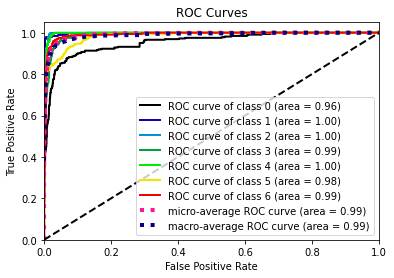

              precision    recall  f1-score   support

     Class 0       0.90      0.61      0.73       323
     class 1       0.95      0.97      0.96       323
     class 2       0.87      1.00      0.93       322
     Class 3       0.81      0.93      0.86       321
     class 4       0.88      0.95      0.92       322
     class 5       0.89      0.79      0.83       321
     Class 6       0.88      0.93      0.90       322

    accuracy                           0.88      2254
   macro avg       0.88      0.88      0.88      2254
weighted avg       0.88      0.88      0.88      2254



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
import random
random.seed(12)

predSVM = rbf_pred #predictions
y_scoreSVM = rbf.predict_proba(X_svmtest)
scoreSVM = rbf.score(X_svmtest, y_svmtest)
print(scoreSVM)
print('Accuracy:',accuracy_score(y_svmtest, predSVM))

print('ROC-AUC SVM :', roc_auc_score(y_svmtest, y_scoreSVM, multi_class='ovr'))
plot_roc(y_svmtest, y_scoreSVM)
plt.show()

target_names = ['Class 0', 'class 1', 'class 2', 'Class 3', 'class 4', 'class 5', 'Class 6']
print(classification_report(y_svmtest, predSVM, target_names=target_names))

In [ ]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=37)

# Defining parameter range
gridSVM = {'C': [0.01, 0.1, 1, 10, 100], 
              'gamma': [0.01, 0.1, 1, 10, 100],
              'kernel': ['rbf']} 
  
grid_svm = GridSearchCV(SVC(decision_function_shape='ovr',probability=True), gridSVM, refit = True, verbose = 3, cv=rskf)
  
# fitting the model for grid search
grid_svm.fit(X_svmtrain, y_svmtrain)

In [ ]:
#Best parameters

grid_svm.best_params_ 